In [1]:
from tensorflow.keras.models import load_model
from pydub import AudioSegment
import numpy as np
from pytube import YouTube 
from moviepy.video.io.VideoFileClip import VideoFileClip
import librosa
import matplotlib.pyplot as plt
import math

In [32]:
from extract_audio_clip import extract_audio_clip

In [34]:
extract_audio_clip('../uploaded_video/court_tmo_interview.mp4','../tmp_sliced_audio/', 'audio', 20, 21)

TypeError: extract_audio_clip() takes from 2 to 4 positional arguments but 5 were given

In [19]:
model = load_model('../models/yt_cats_cnn_1')

In [25]:
def scan_extract_specs(video_path, clip_length=1, hop_length=0.2):
    """
    Extracts spectrograms from the audio of a video file using a sliding window approach.

    Args:
        video_path (str): Path to the video file.
        clip_lenth (int, optional): Length in num of seconds of the sampled audio
        hop_length (int, optional): Length in num of seconds of the interval used to slide across the audio
    
    Returns:
        List of tuples, where each tuple contains the start and end times of an audio clip (in seconds) and its spectrogram.
    """
    # Load the audio file
    audio, sr = librosa.load(video_path)

    # Pad the audio with zeros if necessary
    samples_to_pad = int(clip_length * sr) - (len(audio) % int(clip_length * sr))

    if samples_to_pad > 0:
        audio = np.concatenate((audio, np.zeros(samples_to_pad)))

    # Convert time intervals to samples
    clip_samples = int(clip_length * sr)
    hop_samples = int(hop_length * sr)

    # Calculate the number of clips and the shape of the spectrograms
    n_clips = int(np.ceil(len(audio) / hop_samples)) - int(np.ceil(samples_to_pad / hop_samples))
    spec_shape = librosa.feature.melspectrogram(y=audio[:clip_samples], sr=sr).T.shape

    # Create arrays to store the spectrograms and clip timestamps
    spectrograms = np.zeros((n_clips, spec_shape[0], spec_shape[1]), dtype=np.float32)
    clip_times = []

    # Iterate over the audio and create spectrograms for each clip
    for i in range(n_clips):
        # Calculate the start and end samples for the clip
        start_sample = i * hop_samples
        end_sample = start_sample + clip_samples

        # Extract the audio clip
        audio_clip = audio[start_sample:end_sample]

        # Calculate the spectrogram for the audio clip
        spectrogram = librosa.feature.melspectrogram(y=audio_clip, sr=sr).T

        # Store the spectrogram and clip start time
        spectrograms[i, :, :] = spectrogram
        clip_times.append((start_sample / sr , (start_sample / sr)+ clip_length))

    return spectrograms, clip_times

In [26]:
results = scan_extract_specs('../uploaded_video/court_tmo_interview.mp4')
results

(array([[[1.44408988e-02, 7.47970194e-02, 2.07457244e-01, ...,
          5.96139171e-06, 5.21036827e-06, 7.43926364e-07],
         [6.10461459e-02, 8.43395174e-01, 2.28489280e+00, ...,
          3.42216263e-05, 2.39022575e-05, 3.62033029e-06],
         [1.64794594e-01, 1.37442350e+00, 4.66954660e+00, ...,
          3.21991865e-05, 1.59762658e-05, 2.10791177e-06],
         ...,
         [8.88137221e-01, 8.75610924e+00, 3.64834094e+00, ...,
          2.85181333e-03, 2.05626176e-03, 1.45598649e-04],
         [1.03563225e+00, 7.05175781e+00, 2.94113183e+00, ...,
          3.82312248e-03, 2.62627727e-03, 1.67188438e-04],
         [8.55385423e-01, 2.46084261e+00, 2.20274854e+00, ...,
          6.32058480e-04, 3.49594542e-04, 4.24950376e-05]],
 
        [[1.02062434e-01, 5.42913675e-01, 1.10984278e+00, ...,
          1.56272179e-03, 2.15568434e-04, 3.78930599e-06],
         [1.38915658e-01, 8.10896456e-01, 2.84033442e+00, ...,
          1.09000364e-03, 3.20921768e-04, 9.91496563e-06],
       

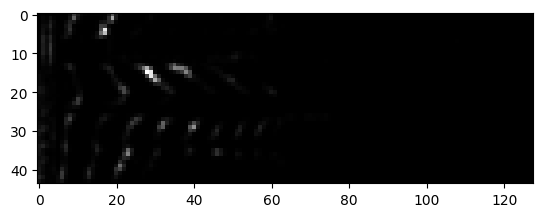

In [35]:
# Access the spectrogram at index 3
spectrogram = results[0][4]

# Display the spectrogram
plt.imshow(spectrogram, cmap='gray')
plt.show()

In [ ]:
def classify_audio_clips(clips):
    X = []
    for clip in clips:
        # Convert audio to spectrogram
        spectrogram = # Your code to generate spectrogram
        
        # Preprocess spectrogram
        preprocessed_spectrogram = # Your code to preprocess spectrogram
        
        X.append(preprocessed_spectrogram)
    
    X = np.array(X)
    
    # Run predictions
    y_pred = model.predict(X)
    
    # Get predicted classes
    predicted_classes = np.argmax(y_pred, axis=1)
    
    return predicted_classes


In [ ]:
def find_most_likely_clips(clips, predicted_classes, video_path):
    clips_by_category = {}
    for i, clip in enumerate(clips):
        category = predicted_classes[i]
        if category not in clips_by_category:
            clips_by_category[category] = []
        clips_by_category[category].append((clip, i))
    
    video = VideoFileClip(video_path)
    
    clips_with_video_timing = {}
    
    for category, clips in clips_by_category.items():
        clips_with_video_timing[category] = []
        for clip, clip_idx in clips:
            start_time = clip_idx * (clip.duration - overlap) / 1000
            end_time = (clip_idx + 1) * (clip.duration - overlap) / 1000
            video_clip = video.subclip(start_time, end_time)
            clips_with_video_timing[category].append(video_clip)
    
    return clips_with_video_timing

In [ ]:
def classify_video(video_path, clip_length, overlap):
    audio = extract_audio(video_path, 0, None)
    clips = generate_audio_clips(audio, clip_length, overlap)
    predicted_classes = classify_audio_clips(clips)
    most_likely_clips = find_most_likely_clips(clips, predicted_classes)
    return most_likely_clips